**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

**MOUNT GOOGLE DRIVE**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Set working directory
import os
project_folder = '/content/drive/MyDrive/FraudDetection'  # Sesuaikan dengan folder kamu
os.makedirs(project_folder, exist_ok=True)
os.chdir(project_folder)

print(f"Working Directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir()}")

# Create subdirectories for organized storage
os.makedirs('data/cleaned', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

print("\n✅ Google Drive mounted and directories created!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory: /content/drive/MyDrive/FraudDetection
Files in directory: []

✅ Google Drive mounted and directories created!


**LOAD THE DATA**

In [5]:
print("\n" + "=" * 60)
print("LOADING DATA")
print("=" * 60)

# Load training data (sesuaikan path dengan lokasi dataset kamu)
train_df = pd.read_csv('/content/drive/MyDrive/datasets/train_transaction.csv')

print(f"\nDataset Shape: {train_df.shape}")
print(f"Total Rows: {train_df.shape[0]:,}")
print(f"Total Columns: {train_df.shape[1]}")


LOADING DATA

Dataset Shape: (590540, 394)
Total Rows: 590,540
Total Columns: 394


**BASIC DATA INFORMATION**

In [6]:
print("\n" + "=" * 60)
print("BASIC DATA INFORMATION")
print("=" * 60)

print("\nFirst 5 rows:")
print(train_df.head())

print("\nData Types:")
print(train_df.dtypes.value_counts())

print("\nDetailed Info:")
train_df.info()

# Memory usage
memory_usage = train_df.memory_usage(deep=True).sum() / 1024**2
print(f"\nTotal Memory Usage: {memory_usage:.2f} MB")


BASIC DATA INFORMATION

First 5 rows:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN  

**TARGET VARIABLE ANALYSIS (CLASS IMBALANCE)**


TARGET VARIABLE ANALYSIS - isFraud

Class Distribution:
Non-Fraud (0): 569,877 (96.50%)
Fraud (1): 20,663 (3.50%)

Imbalance Ratio: 1:27.58
⚠️ Class Imbalance Detected! Need to handle with SMOTE/SMOTEENN

📊 Saved: visualizations/01_class_distribution.png


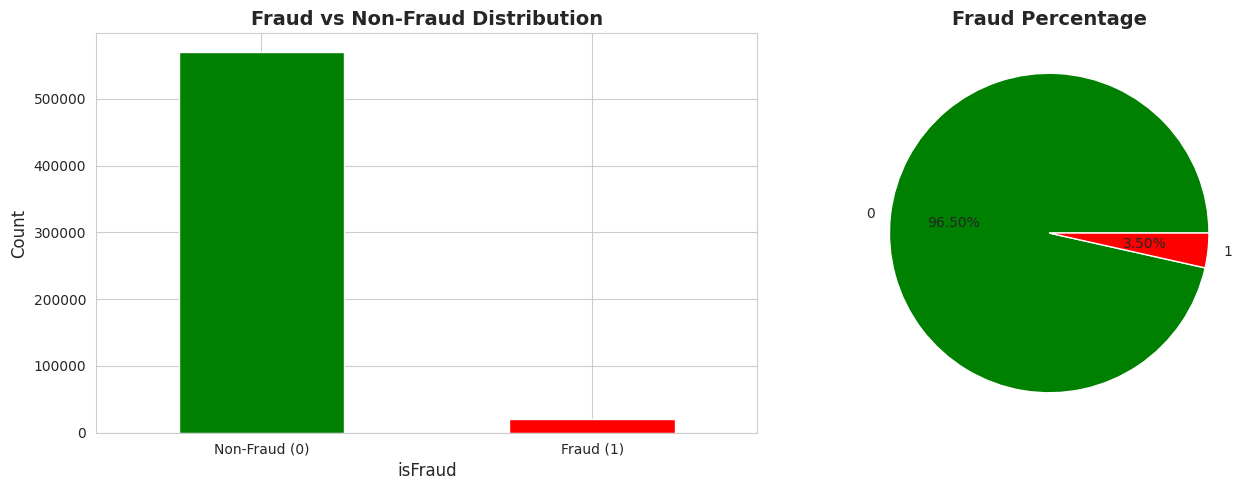

In [7]:
print("\n" + "=" * 60)
print("TARGET VARIABLE ANALYSIS - isFraud")
print("=" * 60)

# Count and percentage
fraud_counts = train_df['isFraud'].value_counts()
fraud_percentage = train_df['isFraud'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(f"Non-Fraud (0): {fraud_counts[0]:,} ({fraud_percentage[0]:.2f}%)")
print(f"Fraud (1): {fraud_counts[1]:,} ({fraud_percentage[1]:.2f}%)")

imbalance_ratio = fraud_counts[0] / fraud_counts[1]
print(f"\nImbalance Ratio: 1:{imbalance_ratio:.2f}")
print(f"⚠️ Class Imbalance Detected! Need to handle with SMOTE/SMOTEENN")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
fraud_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Fraud vs Non-Fraud Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('isFraud', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=0)

# Percentage plot
fraud_percentage.plot(kind='pie', ax=axes[1], autopct='%1.2f%%', colors=['green', 'red'])
axes[1].set_title('Fraud Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('visualizations/01_class_distribution.png', dpi=300, bbox_inches='tight')
print("\n📊 Saved: visualizations/01_class_distribution.png")
plt.show()

**MISSING VALUES ANALYSIS**

In [8]:
print("\n" + "=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

# Calculate missing values
missing_data = pd.DataFrame({
    'Column': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Missing_Percentage': (train_df.isnull().sum() / len(train_df)) * 100,
    'Data_Type': train_df.dtypes
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
).reset_index(drop=True)

if len(missing_data) > 0:
    print(f"\nFound {len(missing_data)} columns with missing values:")
    print(missing_data.to_string())

    # Save missing data report
    missing_data.to_csv('results/01_missing_values_report.csv', index=False)
    print("\n💾 Saved: results/01_missing_values_report.csv")

    # Categorize by severity
    high_missing = missing_data[missing_data['Missing_Percentage'] > 50]
    medium_missing = missing_data[(missing_data['Missing_Percentage'] > 20) &
                                   (missing_data['Missing_Percentage'] <= 50)]
    low_missing = missing_data[missing_data['Missing_Percentage'] <= 20]

    print(f"\n📊 Missing Value Summary:")
    print(f"   High (>50%): {len(high_missing)} columns - Consider dropping")
    print(f"   Medium (20-50%): {len(medium_missing)} columns - Impute with caution")
    print(f"   Low (<20%): {len(low_missing)} columns - Safe to impute")

    # Visualization
    if len(missing_data) <= 20:
        plt.figure(figsize=(12, 6))
        plt.barh(missing_data['Column'], missing_data['Missing_Percentage'], color='coral')
        plt.xlabel('Missing Percentage (%)', fontsize=12)
        plt.ylabel('Column Name', fontsize=12)
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.axvline(x=50, color='red', linestyle='--', label='50% Threshold')
        plt.axvline(x=20, color='orange', linestyle='--', label='20% Threshold')
        plt.legend()
        plt.tight_layout()
        plt.savefig('visualizations/02_missing_values.png', dpi=300, bbox_inches='tight')
        print("📊 Saved: visualizations/02_missing_values.png")
        plt.show()
else:
    print("\n✅ No missing values found!")


MISSING VALUES ANALYSIS

Found 374 columns with missing values:
            Column  Missing_Count  Missing_Percentage Data_Type
0            dist2         552913           93.628374   float64
1               D7         551623           93.409930   float64
2              D13         528588           89.509263   float64
3              D14         528353           89.469469   float64
4              D12         525823           89.041047   float64
5               D6         517353           87.606767   float64
6               D8         515614           87.312290   float64
7               D9         515614           87.312290   float64
8             V154         508595           86.123717   float64
9             V153         508595           86.123717   float64
10            V162         508595           86.123717   float64
11            V161         508595           86.123717   float64
12            V163         508595           86.123717   float64
13            V155         508595      

**DATA TYPES ANALYSIS**

In [9]:
print("\n" + "=" * 60)
print("DATA TYPES ANALYSIS")
print("=" * 60)

# Separate by data types
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target from numeric if present
if 'isFraud' in numeric_cols:
    numeric_cols.remove('isFraud')

print(f"\nNumeric Columns ({len(numeric_cols)}):")
print(numeric_cols[:10], "..." if len(numeric_cols) > 10 else "")

print(f"\nCategorical Columns ({len(categorical_cols)}):")
print(categorical_cols[:10], "..." if len(categorical_cols) > 10 else "")

# Check unique values in categorical columns
cat_unique_info = []
for col in categorical_cols:
    unique_count = train_df[col].nunique()
    cat_unique_info.append({
        'Column': col,
        'Unique_Count': unique_count,
        'Sample_Values': str(train_df[col].dropna().unique()[:5].tolist())
    })

cat_unique_df = pd.DataFrame(cat_unique_info)
print("\nCategorical Columns - Unique Values:")
print(cat_unique_df.head(10).to_string())

# Save data types info
cat_unique_df.to_csv('results/01_categorical_info.csv', index=False)
print("\n💾 Saved: results/01_categorical_info.csv")


DATA TYPES ANALYSIS

Numeric Columns (379):
['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1'] ...

Categorical Columns (14):
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5'] ...

Categorical Columns - Unique Values:
          Column  Unique_Count                                                                Sample_Values
0      ProductCD             5                                                    ['W', 'H', 'C', 'S', 'R']
1          card4             4                       ['discover', 'mastercard', 'visa', 'american express']
2          card6             4                        ['credit', 'debit', 'debit or credit', 'charge card']
3  P_emaildomain            59       ['gmail.com', 'outlook.com', 'yahoo.com', 'mail.com', 'anonymous.com']
4  R_emaildomain            60  ['gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com', 'charter.net']
5             M1      

**STATISTICAL SUMMARY FOR NUMERIC COLUMNS**

In [10]:
print("\n" + "=" * 60)
print("STATISTICAL SUMMARY - NUMERIC COLUMNS")
print("=" * 60)

numeric_summary = train_df[numeric_cols].describe().T
print(numeric_summary)

# Save statistical summary
numeric_summary.to_csv('results/01_numeric_summary.csv')
print("\n💾 Saved: results/01_numeric_summary.csv")


STATISTICAL SUMMARY - NUMERIC COLUMNS
                   count          mean           std          min  \
TransactionID   590540.0  3.282270e+06  1.704744e+05  2987000.000   
TransactionDT   590540.0  7.372311e+06  4.617224e+06    86400.000   
TransactionAmt  590540.0  1.350272e+02  2.391625e+02        0.251   
card1           590540.0  9.898735e+03  4.901170e+03     1000.000   
card2           581607.0  3.625555e+02  1.577932e+02      100.000   
...                  ...           ...           ...          ...   
V335             82351.0  5.916455e+01  3.876295e+02        0.000   
V336             82351.0  2.853090e+01  2.745769e+02        0.000   
V337             82351.0  5.535242e+01  6.684868e+02        0.000   
V338             82351.0  1.511605e+02  1.095034e+03        0.000   
V339             82351.0  1.007009e+02  8.149467e+02        0.000   

                        25%          50%          75%           max  
TransactionID   3134634.750  3282269.500   3429904.25  3.57753

**OUTLIERS DETECTION**

In [11]:
print("\n" + "=" * 60)
print("OUTLIERS DETECTION (IQR Method)")
print("=" * 60)

def detect_outliers_iqr(df, columns, sample_size=5):
    """Detect outliers using IQR method for sample columns"""
    outlier_info = []

    for col in columns[:sample_size]:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100

        outlier_info.append({
            'Column': col,
            'Outlier_Count': outlier_count,
            'Outlier_Percentage': outlier_pct,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })

    return pd.DataFrame(outlier_info)

# Detect outliers for first 5 numeric columns
outlier_df = detect_outliers_iqr(train_df, numeric_cols, sample_size=5)
print("\nOutlier Detection (Sample - First 5 Numeric Columns):")
print(outlier_df.to_string())

# Save outlier report
outlier_df.to_csv('results/01_outliers_report.csv', index=False)
print("\n💾 Saved: results/01_outliers_report.csv")


OUTLIERS DETECTION (IQR Method)

Outlier Detection (Sample - First 5 Numeric Columns):
           Column  Outlier_Count  Outlier_Percentage   Lower_Bound   Upper_Bound
0   TransactionID              0            0.000000  2.691730e+06  3.872808e+06
1   TransactionDT              0            0.000000 -9.302286e+06  2.357596e+07
2  TransactionAmt          66482           11.257832 -7.919750e+01  2.475185e+02
3           card1              0            0.000000 -6.228500e+03  2.643150e+04
4           card2              0            0.000000 -2.330000e+02  9.590000e+02

💾 Saved: results/01_outliers_report.csv


**DUPLICATE RECORDS CHECK**

In [12]:
print("\n" + "=" * 60)
print("DUPLICATE RECORDS CHECK")
print("=" * 60)

duplicate_count = train_df.duplicated().sum()
duplicate_pct = (duplicate_count / len(train_df)) * 100

print(f"\nDuplicate Rows: {duplicate_count} ({duplicate_pct:.2f}%)")

if duplicate_count > 0:
    print(f"⚠️ Found duplicates! Consider removing in preprocessing.")
else:
    print("✅ No duplicate rows found!")


DUPLICATE RECORDS CHECK

Duplicate Rows: 0 (0.00%)
✅ No duplicate rows found!


**CORRELATION ANALYSIS (Sample)**


CORRELATION ANALYSIS WITH TARGET (Sample)

Top 10 Positive Correlations with isFraud:
V257    0.383060
V246    0.366878
V244    0.364129
V242    0.360590
V201    0.328005
V200    0.318783
V189    0.308219
V188    0.303582
V258    0.297151
V45     0.281832
Name: isFraud, dtype: float64

Top 10 Negative Correlations with isFraud:
V70   -0.100900
V30   -0.103088
V69   -0.104521
V91   -0.105453
V29   -0.107852
V90   -0.110168
V49   -0.110920
V48   -0.115786
D7    -0.127199
D8    -0.142636
Name: isFraud, dtype: float64

💾 Saved: results/01_correlation_with_target.csv
📊 Saved: visualizations/03_correlation_analysis.png


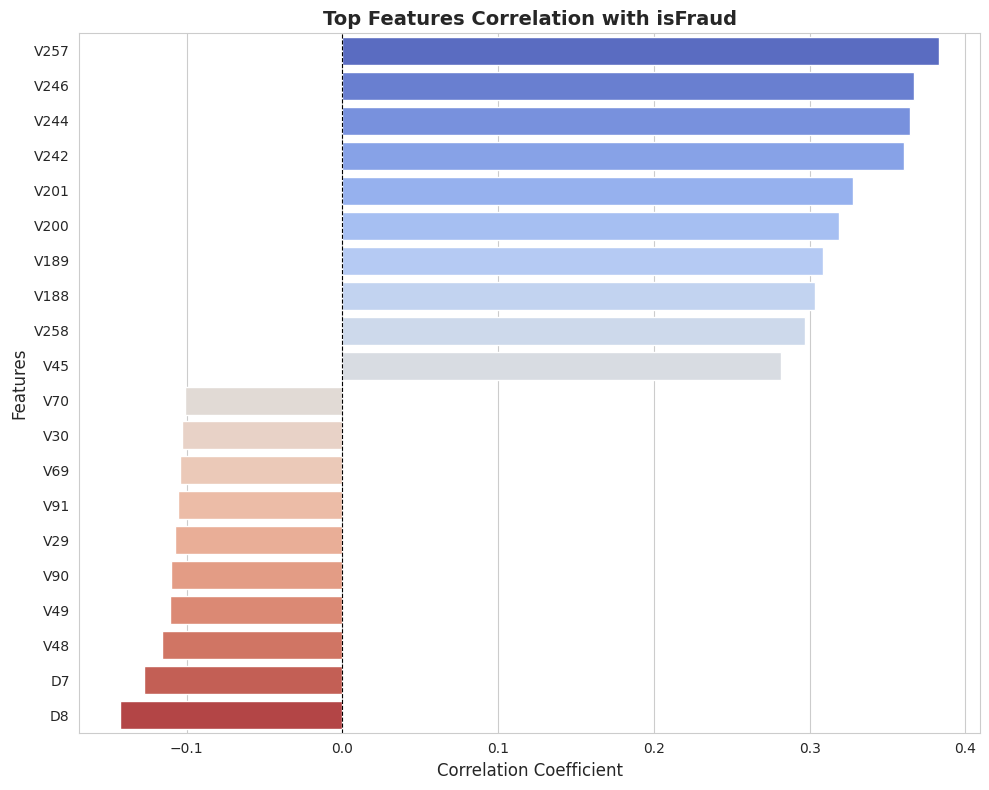

In [13]:
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS WITH TARGET (Sample)")
print("=" * 60)

# Calculate correlation with target for numeric columns
if len(numeric_cols) > 0:
    correlation_with_target = train_df[numeric_cols + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)

    print("\nTop 10 Positive Correlations with isFraud:")
    print(correlation_with_target.head(11)[1:11])  # Exclude isFraud itself

    print("\nTop 10 Negative Correlations with isFraud:")
    print(correlation_with_target.tail(10))

    # Save correlation report
    correlation_with_target.to_csv('results/01_correlation_with_target.csv', header=['Correlation'])
    print("\n💾 Saved: results/01_correlation_with_target.csv")

    # Visualization
    plt.figure(figsize=(10, 8))
    top_corr = pd.concat([correlation_with_target.head(11)[1:11],
                          correlation_with_target.tail(10)])
    sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Top Features Correlation with isFraud', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('visualizations/03_correlation_analysis.png', dpi=300, bbox_inches='tight')
    print("📊 Saved: visualizations/03_correlation_analysis.png")
    plt.show()

**PREPROCESSING RECOMMENDATIONS**

In [14]:
print("\n" + "=" * 60)
print("PREPROCESSING RECOMMENDATIONS")
print("=" * 60)

recommendations = []

# Class imbalance
if imbalance_ratio > 10:
    recommendations.append("✓ Apply SMOTE or SMOTEENN to handle severe class imbalance")

# Missing values
if len(missing_data) > 0:
    high_missing_cols = missing_data[missing_data['Missing_Percentage'] > 50]['Column'].tolist()
    if len(high_missing_cols) > 0:
        recommendations.append(f"✓ Drop {len(high_missing_cols)} columns with >50% missing values")

    medium_low_missing = missing_data[missing_data['Missing_Percentage'] <= 50]
    if len(medium_low_missing) > 0:
        recommendations.append(f"✓ Impute {len(medium_low_missing)} columns with median (numeric) or mode (categorical)")

# Duplicates
if duplicate_count > 0:
    recommendations.append(f"✓ Remove {duplicate_count} duplicate rows")

# Categorical encoding
if len(categorical_cols) > 0:
    recommendations.append(f"✓ Encode {len(categorical_cols)} categorical columns using Label Encoding or One-Hot Encoding")

# Feature scaling
if len(numeric_cols) > 0:
    recommendations.append(f"✓ Scale {len(numeric_cols)} numeric features using StandardScaler or MinMaxScaler")

# Outliers
outlier_cols = outlier_df[outlier_df['Outlier_Percentage'] > 5]['Column'].tolist()
if len(outlier_cols) > 0:
    recommendations.append(f"✓ Handle outliers in columns with >5% outliers (consider capping or transformation)")

# Feature selection
if len(numeric_cols) > 50:
    recommendations.append("✓ Apply feature selection to reduce dimensionality and improve performance")

print("\nRecommended Preprocessing Steps:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

# Save recommendations
with open('results/01_preprocessing_recommendations.txt', 'w') as f:
    f.write("PREPROCESSING RECOMMENDATIONS\n")
    f.write("=" * 60 + "\n\n")
    for i, rec in enumerate(recommendations, 1):
        f.write(f"{i}. {rec}\n")
    f.write(f"\nClass Imbalance Ratio: 1:{imbalance_ratio:.2f}\n")
    f.write(f"Total Missing Columns: {len(missing_data)}\n")
    f.write(f"Duplicate Rows: {duplicate_count}\n")

print("\n💾 Saved: results/01_preprocessing_recommendations.txt")


PREPROCESSING RECOMMENDATIONS

Recommended Preprocessing Steps:
1. ✓ Apply SMOTE or SMOTEENN to handle severe class imbalance
2. ✓ Drop 174 columns with >50% missing values
3. ✓ Impute 200 columns with median (numeric) or mode (categorical)
4. ✓ Encode 14 categorical columns using Label Encoding or One-Hot Encoding
5. ✓ Scale 379 numeric features using StandardScaler or MinMaxScaler
6. ✓ Handle outliers in columns with >5% outliers (consider capping or transformation)
7. ✓ Apply feature selection to reduce dimensionality and improve performance

💾 Saved: results/01_preprocessing_recommendations.txt


**SAVE COLUMN LISTS FOR NEXT NOTEBOOKS**

In [16]:
print("\n" + "=" * 60)
print("SAVING COLUMN INFORMATION")
print("=" * 60)

# Save column lists for reference in next notebooks
column_info = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'all_columns': train_df.columns.tolist()
}

import pickle
with open('results/01_column_info.pkl', 'wb') as f:
    pickle.dump(column_info, f)

print("💾 Saved: results/01_column_info.pkl")


SAVING COLUMN INFORMATION
💾 Saved: results/01_column_info.pkl


**MEMORY CLEANUP**

In [17]:
print("\n" + "=" * 60)
print("MEMORY CLEANUP")
print("=" * 60)

print(f"\nMemory before cleanup: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Clear variables
del fraud_counts, fraud_percentage
if 'correlation_with_target' in locals():
    del correlation_with_target
if 'outlier_df' in locals():
    del outlier_df

gc.collect()

print(f"Memory after cleanup: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 60)
print("NOTEBOOK 1 COMPLETE!")
print("=" * 60)
print("\n📁 All results saved to Google Drive:")
print("   - Visualizations: visualizations/")
print("   - Reports: results/")
print("   - Next step: Proceed to Notebook 2 for preprocessing")
print("=" * 60)


MEMORY CLEANUP

Memory before cleanup: 2062.07 MB
Memory after cleanup: 2062.07 MB

NOTEBOOK 1 COMPLETE!

📁 All results saved to Google Drive:
   - Visualizations: visualizations/
   - Reports: results/
   - Next step: Proceed to Notebook 2 for preprocessing
